# Homework 05 — IANNwTF
## Group 27
Deadline: Nov 28, 2021 23:59

<https://forms.gle/8qwiuUXCfLjKGeg67>

In [1]:
# important libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Dataset

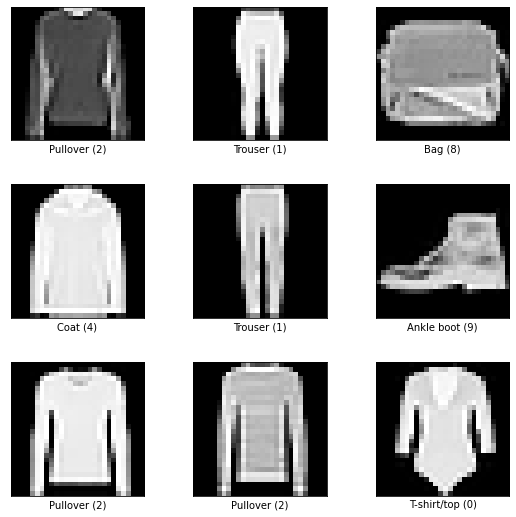

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [2]:
(train_ds, test_ds), info = tfds.load('fashion_mnist', split=['train', 'test'], shuffle_files=True, with_info=True, as_supervised=True)
fig = tfds.show_examples(train_ds, info)
print(info)

In [3]:
for elem in train_ds.take(1):
    print("Image dimensions: ", elem[0].shape)
    print("Target: ", elem[1])

Image dimensions:  (28, 28, 1)
Target:  tf.Tensor(2, shape=(), dtype=int64)


In [4]:
def prepare_fashion_mnist_data(ds):
    # convert data from uint8 to float32
    ds = ds.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # input normalization: bringing image values from range [0, 255] to [-1, 1]
    ds = ds.map(lambda img, target: ((img/128.)-1., target))
    # create one-hot targets
    ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # cache this progress in memory
    ds = ds.cache()
    # shuffle, batch, prefetch
    ds = ds.shuffle(1000).batch(8).prefetch(20)
    # return preprocessed dataset
    return ds


In [5]:
train_ds = train_ds.apply(prepare_fashion_mnist_data)
test_ds = test_ds.apply(prepare_fashion_mnist_data)

In [6]:
for elem in train_ds.take(1):
    print("Image dimensions: ", elem[0].shape)
    input_shape = np.array(elem[0].shape) # save shape of model input for later when building the model
    print("Target: ", elem[1])

Image dimensions:  (8, 28, 28, 1)
Target:  tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]], shape=(8, 10), dtype=float32)


# Model

In [7]:
n_outputs = 4 # number of filters to be applied in the convolutional layers


In [8]:
##### this is just a DRAFT!

# Custom Model
class MyModel(tf.keras.Model):
    """ 
    Custom CNN model for a classification task, which inherits from the keras.Model class

    Functions:
    init: constructor
    call: performs forward pass
    """
    
    def __init__(self):
        '''
        Constructs the model with X layers, and 1 dense layer with 10 output neurons
        '''
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(8, (5, 5), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(24, (3, 3), padding='same')        
        self.pool3 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
        self.pool4 =  tf.keras.layers.GlobalAveragePooling2D()
        self.out = tf.keras.layers.Dense(10, activation ='softmax') # output layer with 10 units (we have 10 classes) and softmax activation

    def call(self, inputs):
        '''
        Performs a forward step in our MLP
        
        Args:
          inputs (Tensor): input to the model
        
        Returns: 
          x: output of the model
        '''
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pool3(x)
        x = self.pool4(x)
        x = self.out(x)
        return x

# Training

In [9]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    # test over complete test data
    
    test_accuracy_aggregator = []
    test_loss_aggregator = []
    
    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
        
    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)
    
    return test_loss, test_accuracy

In [10]:
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

# Testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs
for epoch in range(num_epochs):
    print('Epoch: {0} starting with accuracy {1:.2f}'.format(epoch,test_accuracies[-1]))

    # Training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    # Track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    # Testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.20
Epoch: 1 starting with accuracy 0.48
Epoch: 2 starting with accuracy 0.33
Epoch: 3 starting with accuracy 0.59
Epoch: 4 starting with accuracy 0.58
Epoch: 5 starting with accuracy 0.59
Epoch: 6 starting with accuracy 0.56
Epoch: 7 starting with accuracy 0.33
Epoch: 8 starting with accuracy 0.58
Epoch: 9 starting with accuracy 0.49


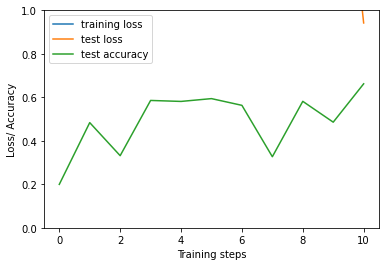

'\n# Play an audio beep. Any audio URL will do.\nfrom google.colab import output\noutput.eval_js(\'new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()\')\n'

In [14]:
# Visualize accuracy and loss for training and test data
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/ Accuracy")
plt.legend((line1,line2, line3),("training loss","test loss", "test accuracy"))
plt.ylim(0,1)
plt.show()

'''
# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
'''